# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloFinal.pkl") 
variables = open('./ModeloFinal.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloFinal.txt','r')
var_input = variables.read()

In [12]:
var_input = ['branch_minutes_since_last_transaction',  
    'branch_trans_3m', 'count_date_receiver_distinct', 'branch_has_fraud', 
    'receiver_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', '01_receiver_fraud', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [14]:
convert_dict = {'branch_minutes_since_last_transaction': float
                }
 
testeo = testeo.astype(convert_dict)

In [15]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()

In [16]:
corte

1.2674839367177377e-08

In [17]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [18]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [19]:
convert_dict = {'branch_minutes_since_last_transaction': float
                }
 
testeo = testeo.astype(convert_dict)

In [20]:
testeo['target'].value_counts(dropna=False)

target
False    26478251
True          759
Name: count, dtype: int64

In [21]:
Y_target.shape

(26479010, 8)

In [22]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [23]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [24]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,26478248,3
1,218,541


In [25]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,26194983,283268
1,25,734


<Axes: xlabel='score_rf', ylabel='Count'>

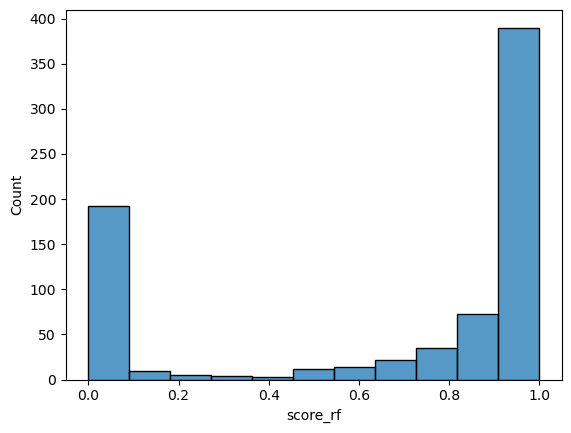

In [26]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [27]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA 30%:
0.9828722002635046


In [28]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,264057,734
2,264783,7
3,264785,5
4,264790,0
5,264789,1
...,...,...
96,264790,0
97,264790,0
98,264790,0


In [29]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.433745e-08  1.000000e+00
2             4.264509e-09  1.433728e-08
3             2.117429e-09  4.264509e-09
4             1.295752e-09  2.117423e-09
5             8.847780e-10  1.295749e-09
...                    ...           ...
96            4.152087e-13  4.840233e-13
97            3.447804e-13  4.152084e-13
98            2.696772e-13  3.447798e-13
99            1.831738e-13  2.696759e-13
100           2.980758e-15  1.831728e-13

[100 rows x 2 columns]

In [30]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,37641,34143,32467,32234,40796,46334,41176
2,37327,32243,30225,30211,42956,48830,42998
3,37249,31898,29420,29314,43191,49703,44015
4,36623,31394,28795,29499,44160,49994,44325
5,37077,31060,28503,28744,43863,51137,44406
6,36906,31143,28529,28669,44434,50592,44517
7,37003,30954,27931,28373,44423,50960,45146
8,36984,30915,27790,28186,44674,51322,44919
9,36776,30655,27870,28176,44491,51688,45134


In [31]:
#DECILES.to_csv ('./deciles.csv')

## Curva ROC y FP

In [32]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [33]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.907769644289514
ROC FRAUD TESTEO:
0.9781818924745264


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9587824581897494
Precision FRAUD TESTEO:
0.0025844888416278757
Recall FRAUD TESTEO:
0.9670619235836627


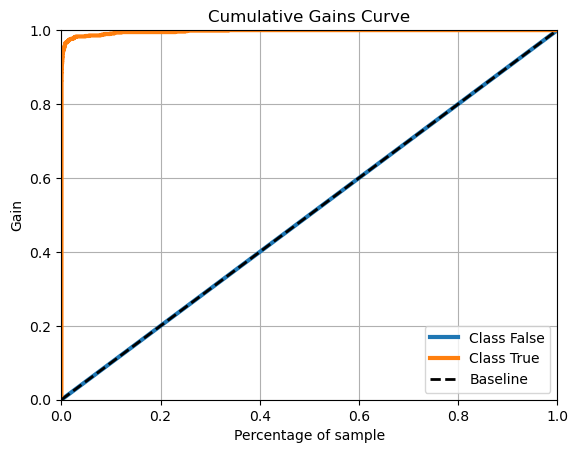

In [34]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


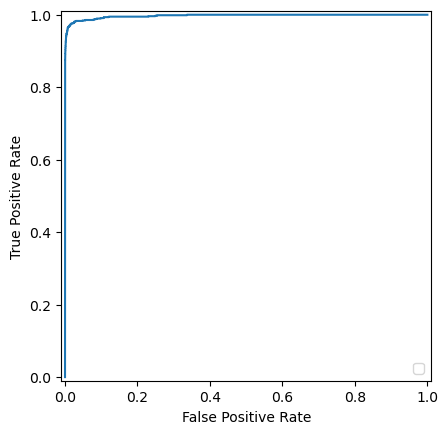

In [35]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

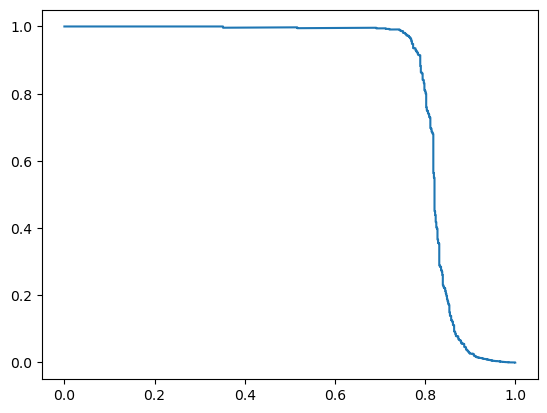

In [36]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [37]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

0.8002628120893561

## Monthly analysis

In [38]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,1717213,118
2,1765421,58
3,2030736,44
4,2116210,87
5,2289906,69
6,2193665,101
7,2314235,50
8,2296955,68
9,2420676,75


In [39]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,18346,118
2,17943,58
3,20727,44
4,21105,85
5,22543,69
6,24242,101
7,19678,50
8,22072,68
9,25606,64


In [40]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [41]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,17276,17419,17880,18224,18752,18621,19191,19265,19525,19679,19913,19678,20019,19999,20484,20275,20403,20499,20194,20254,20476,20538,20567,20200,20374,20293,20377,20503,20645,20548,20265,20586,20332,20562,20341,20119,20328,20004,20060,20243,19881,19775,19926,19474,19777,19622,19557,19471,19372,19295,18958,19191,18794,18702,18822,18437,18465,18446,18244,17954,17929,17716,17535,17428,17308,17159,16942,16824,16608,16306,16393,16081,15967,15586,15467,14978,14893,14662,14561,14129,13836,13675,13362,12913,12740,12508,12252,11546,11443,11153,10758,10304,9833,9654,9382,9040,8518,8096,7729,7043
2,16740,17545,17772,18263,18527,19067,19007,19487,19522,19567,20062,20155,20144,20263,20373,20423,20485,20844,20724,20614,20774,20685,20678,20568,20796,20466,20820,20857,21129,20667,20795,20802,20616,20701,20480,20817,20403,20634,20672,20443,20238,20510,20305,20196,20395,19942,19842,19884,19542,19706,19506,19554,19520,19301,19022,18811,19266,18889,18838,18459,18346,18192,18451,17941,17730,17664,17517,17522,17310,17362,16786,16815,16331,16327,15977,15651,15636,15509,14987,14974,14887,14375,14077,13955,13686,13280,13133,12850,12203,12034,11448,11313,10818,10537,10221,9785,9426,9039,8623,7648
3,19353,19582,19515,19651,19958,20129,20313,20421,20484,20768,20477,20744,20794,20888,20823,20927,20824,21159,20823,21187,21341,21098,21260,21446,21345,21565,21584,21098,21460,21265,21321,21563,21401,21623,21184,21279,21325,21473,21566,21275,21232,21423,21474,21472,21463,21287,21066,21391,21291,21259,21346,21321,20976,21288,21269,21180,20955,20982,21095,20980,20772,20773,20781,20649,20395,20663,20573,20636,20456,20485,20597,20170,20338,20085,20207,20242,19919,19861,19996,19682,19721,19678,19573,19460,19539,19004,18914,18995,18782,18657,18462,18320,18054,17981,17403,16977,17021,16194,15818,13905
4,19706,20618,21298,21592,21831,22233,22540,22604,22638,22842,22973,23156,23276,23611,23223,23886,23584,23768,23946,23951,23728,23758,23948,24252,23696,23736,23770,24144,23948,23681,23997,24124,23918,23794,24033,23965,23903,23634,23675,23738,23503,23791,23633,23338,23267,23383,23407,23414,23134,23174,23215,22823,22874,22780,22556,22731,22365,22390,22409,22016,22176,21893,21796,21672,21413,21323,21494,20900,21278,20649,20474,20518,20387,20076,19733,19707,19422,19219,18874,19030,18458,18255,17924,17623,17211,17039,16941,16376,16190,16117,15569,15164,15178,14825,14555,13997,13650,13251,12862,12157
5,21049,22506,22627,22806,22687,22937,22877,23332,23118,23011,22955,22908,23123,23089,23005,22968,22877,22926,22884,22747,22958,22976,22564,22822,23074,22799,22948,22841,22502,22953,22584,22481,22824,22879,22951,22997,22884,22760,22618,22597,23111,22836,22492,22909,22874,22590,22725,22483,22675,22601,22969,22702,22636,22780,23102,22786,22791,22740,22788,22780,22671,22716,22719,22881,22805,22915,22751,22990,22778,22607,23072,22716,22785,22908,23010,22876,22657,22789,22567,22706,22501,22756,22572,22832,22811,22959,22931,22718,22785,22974,22972,23304,23171,23214,23351,23825,23805,24988,25430,24343
6,22658,22977,22544,22326,22184,21948,21724,21943,21352,21462,21401,21468,21118,20824,20853,20986,21052,20791,21013,20806,20531,20860,20585,20546,20223,20547,20523,20126,20265,20339,20369,20091,20309,20192,20352,20264,20232,20240,20096,20143,20490,20383,20293,20406,20154,20147,20080,20388,20434,20307,20423,20358,20350,20157,20249,20469,20640,20232,20377,20401,20513,20730,20923,20530,20903,20787,20937,20904,20993,20832,21020,21334,21274,21655,21581,21816,21743,22054,22269,22302,22378,22574,23064,23412,23811,24045,23953,24541,24896,25355,25691,26532,26822,27541,27987,29152,29824,31018,3121

In [42]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,5,6,8,9,10,11,13,24,25,26,34
mes,,,,,,,,,,,,,,
1,118,0,0,0,0,0,0,0,0,0,0,0,0,0
2,58,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44,0,0,0,0,0,0,0,0,0,0,0,0,0
4,85,1,1,0,0,0,0,0,0,0,0,0,0,0
5,69,0,0,0,0,0,0,0,0,0,0,0,0,0
6,101,0,0,0,0,0,0,0,0,0,0,0,0,0
7,50,0,0,0,0,0,0,0,0,0,0,0,0,0
8,68,0,0,0,0,0,0,0,0,0,0,0,0,0
9,64,2,2,0,1,0,0,1,1,1,1,1,0,1


In [43]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
36142,1,Real,1
101743,4,Real,1
122591,8,Real,1
124840,7,Real,1
162592,6,Distraction,1
...,...,...,...
25189173,12,Real,1
25250300,12,Distraction,2
25911348,12,Real,11
25941611,12,Real,1


# Monthly indicators

In [44]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [45]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte'])
        recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte'])
        summary_metrics.loc[i,'month'] = m
        summary_metrics.loc[i,'year'] = y
        summary_metrics.loc[i,'precision'] = precision
        summary_metrics.loc[i,'recall'] = recall
        summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte'].sum()
        summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
        summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
        summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
        #print ('Year:', y, 'Month:',m)
        #print ('Precision:', precision, 'Recall:',recall)
        i = i+1
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.003466,1.0,18464,118,64,64
7,2,2023,0.001889,1.0,18001,58,34,34
4,3,2023,0.000963,1.0,20771,44,20,20
1,4,2023,0.002832,0.983607,21190,87,61,60
3,5,2023,0.00199,1.0,22612,69,45,45
0,6,2023,0.002876,1.0,24343,101,70,70
2,7,2023,0.001521,1.0,19728,50,30,30
5,8,2023,0.001671,1.0,22140,68,37,37
8,9,2023,0.001402,0.857143,25670,75,42,36
9,10,2023,0.001021,0.875,27434,46,32,28


In [46]:
summary_metrics.sort_values('month')

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.003466,1.0,18464,118,64,64
7,2,2023,0.001889,1.0,18001,58,34,34
4,3,2023,0.000963,1.0,20771,44,20,20
1,4,2023,0.002832,0.983607,21190,87,61,60
3,5,2023,0.00199,1.0,22612,69,45,45
0,6,2023,0.002876,1.0,24343,101,70,70
2,7,2023,0.001521,1.0,19728,50,30,30
5,8,2023,0.001671,1.0,22140,68,37,37
8,9,2023,0.001402,0.857143,25670,75,42,36
9,10,2023,0.001021,0.875,27434,46,32,28


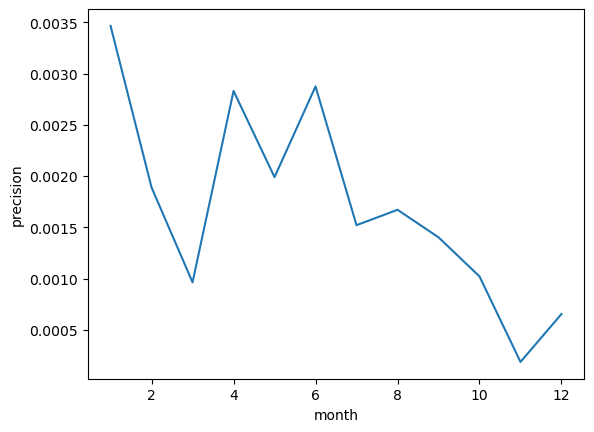

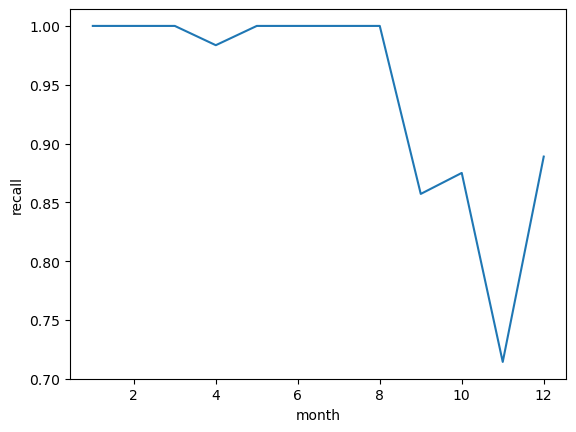

In [47]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()